# Functions and set up used to fit MaNGA stacked spectra of the central regions of RPSBs
23/03/2025

In [1]:
import numpy as np 
import bagpipes as pipes
from astropy.io import fits
from PyAstronomy import pyasl
import pandas as pd
import json
import os

import sys
from code_bits.add_ceh_funcs import *
from code_bits.add_GP_SHOTerm import *
from code_bits.add_VW07_dust import *
from code_bits.fitting_MaNGA import *

Bagpipes: PyMultiNest import failed, fitting will use the Nautilus sampler instead.


In [2]:
# change working directory to one layer above
os.chdir('..')

In [3]:
# some fitting config
plotgal = True    # True = plot diagnostic plot from input galaxy object before fitting
nofit = False       # True = do not fit anything

In [4]:
# process skylines
np_arr = np.loadtxt('data/skylines.txt')
lines_air_df = pd.DataFrame(np_arr, columns=['wavelength', 'width', 'flux'])
lines_vac_sky = pyasl.airtovac2(lines_air_df[lines_air_df['flux']>=5]['wavelength'])

In [5]:
# use drpall to get the redshift of galaxy
# get drpall file here https://www.sdss4.org/dr17/manga/manga-data/catalogs
hdu = fits.open('../../../PSB_MaNGA/MaNGA_DR17/drpall-v3_1_1.fits')
drpall = hdu[1].data
cols = hdu[1].columns
hdu.close()

# Find all datacubes 
ind = ((drpall['mngtarg1'] != 0) | (drpall['mngtarg3'] != 0))

# Find galaxies excluding those from the Coma, IC342, M31 ancillary programs (bits 19,20,21)
targ3 = drpall['mngtarg3']
drpall_tmp = drpall[ind & ((targ3 & 1<<19) == 0) & ((targ3 & 1<<20) == 0) & ((targ3 & 1<<21) == 0)]
#print('Number of galaxies', len(drpall_tmp))

# Get unique galaxies (not necessary here)
#uniq_vals, uniq_idx=np.unique(drpall_tmp['mangaid'], return_index=True)
#drpall_gal = drpall_tmp[uniq_idx]
#print('Unique galaxies', len(uniq_galaxies))

drpall_gal = drpall_tmp
ngal= len(drpall_gal)
drpall = 0

all_IDs = np.array(drpall_gal['plateifu'])
all_zspec = np.array(drpall_gal['nsa_z'])

In [6]:
# initialize run_params dictionary that holds all config information
# for the run
run_params = {}

In [7]:
def get_fit_instructions(redshift, GP=True, dust_type="VW07", Av=(0, 3), eta=(1.0, 3.0), 
                         use_nebular=True, zmet_lims=(0.01,2.5), zmet_prior=None, 
                         GPtype=None, GPclamp=False, 
                         SHOTerm_period_prior=None, SHOTerm_norm_prior=None):
    """ Set up the desired fit_instructions dictionary. """
    dust = {}
    dust["type"] = dust_type
    dust["eta"] = eta                    # extra multiplication factor in birth clouds
    dust["Av"] = Av                      # extinction in V band
    if dust_type == "CF00":
        dust["n"] = 0.7                  # dust slow
    
    # use nebular component
    nebular = {}
    nebular["logU"] = -3                 # the ionization parameter
    
    # the double power law SFH model
    dpl = {}
    dpl["massformed"] = (6, 13)          # vary log_10(M*/M_solar) between 1 and 15
    dpl["metallicity"] = zmet_lims       # vary Z between 0.1 and 2.5 Z_solar
    if zmet_prior is not None:
        dpl["metallicity_prior"] = zmet_prior      # Uniform in log 10 space
    dpl["tau"] = (0, 14)                 # Vary age of turnover between 0 and 14 Gyr.
    dpl["alpha"] = (0.01,250)            # decline slope coefficient
    dpl["alpha_prior"] = "log_10"
    dpl["beta"] = (0.01,250)             # rising slope coefficient: fixed
    dpl["beta_prior"] = "log_10"
    
    noise = {}
    noise["scaling"] = (0.1, 10.)
    noise["scaling_prior"] = "log_10"
    if GP == False:
        noise["type"] = "white_scaled"
    else:
        if GPtype == 'GP_SHOTerm' or GPtype == 'GP_SHOTerm2':
            noise["period"] = SHOTerm_period_prior           # rho, controls length scale of GP covariance
            noise["period_prior"] = "log_10"
            noise["Q"] = 0.49                                # dampening quality factor
            noise["norm"] = SHOTerm_norm_prior
            noise["norm_prior"] = "log_10"
            noise["clamped"] = GPclamp                       # whether to modify the likelihood function to downweight posterior samples
                                                             # with problematic GP noise realizations
        elif GPtype == 'GP_exp_squared':
            noise["length"] = (0.01, 10.)                    # l noise, lengthscale of GP covariance 
            noise["length_prior"] = "log_10"
            noise["norm"] = (0.01, 1.)                       # n noise, amplitude of GP covariance
            noise["norm_prior"] = "log_10"
        noise["type"] = GPtype
    
    fit_instructions = {}
    fit_instructions["dust"] = dust
    if use_nebular:
        fit_instructions["nebular"] = nebular
    fit_instructions["dblplaw"] = dpl
    fit_instructions["noise"] = noise
    fit_instructions["t_bc"] = 0.01
    fit_instructions["veldisp"] = (40., 4000.)
    fit_instructions["veldisp_prior"] = "log_10"
    # vary redshift in -20% to +20% prior, redshift given by MaNGA drpall
    fit_instructions['redshift'] = (redshift-0.2*redshift, redshift+0.2*redshift)
    
    return fit_instructions

In [8]:
# list of targets to fit
all_plateifu = ['8324-12701']
skylines_dir = 'data'

# fill in run_params

#======= input spectrum params =======#
run_params['data_file_extension'] = '_RPSB_centralspx_dereddened_170624'
# binning of consecutive wavelength bins, default no binning
run_params['bin_by'] = 1
# directory where spectrum and related files are in
run_params['spectrum_dir'] = 'data/stacked_spectrum_central'
# specify the emission lines that we mask
run_params['balmer_infilling_masking'] = False
# OII, OII, NeIII, OIII, OIII, OI, ? : in vaccuum
run_params['mask_em_vals'] = [3727.092,3729.875,3870.,
                               4960.295,5008.24,
                               6302.046, 6918.6]

#======= fitting params =======#
run_params['runID_extension'] = '_RPSB_centralspx_Pdemo_dpl_no_red_phot_dereddened_binby1_Rspec4340_nebularEM'
# spectral resolution to set bagpipes to generate its templates in
run_params['Rspec'] = 4340
# whether to fit the red tail at lambda>7500 AA as a single photometric point
# default false
run_params['red_phot'] = False
run_params['dust_type'] = "VW07"
run_params['Av'] = (1.0, 3.0)
run_params['eta'] = (1.0, 5.0)
run_params['nebular'] = True
run_params['GP'] = True
run_params['GPtype'] = 'GP_SHOTerm2'
run_params['SHOTerm_period_prior'] = (0.04,1.0)
run_params['SHOTerm_norm_prior'] = (0.0001,0.1)
run_params['GPclamp'] = True
run_params['SFHcomp'] = 'dblplaw'
run_params['zmet_lims'] = (0.01, 2.5)
run_params['zmet_prior'] = 'log_10'
# nautilus settiings
run_params['sampler'] = "nautilus"
run_params['n_eff'] = 5000                # number of effective samples to draw during sampling phase
run_params['pool'] = 1                    # number of parallel cores used
run_params['discard_exploration'] = True
run_params['delete_raw_files'] = True
run_params['equal_weight_samples'] = True
run_params['n_live'] = 800                # nautilus number of live points, default 400

In [9]:
# some drpall redshifts from NSA are offset. This file corrects for
# a better redshift starting point to set the redshift prior
replace_z = pd.read_fwf(run_params['spectrum_dir']+
                          "/redshift_adjust.txt")

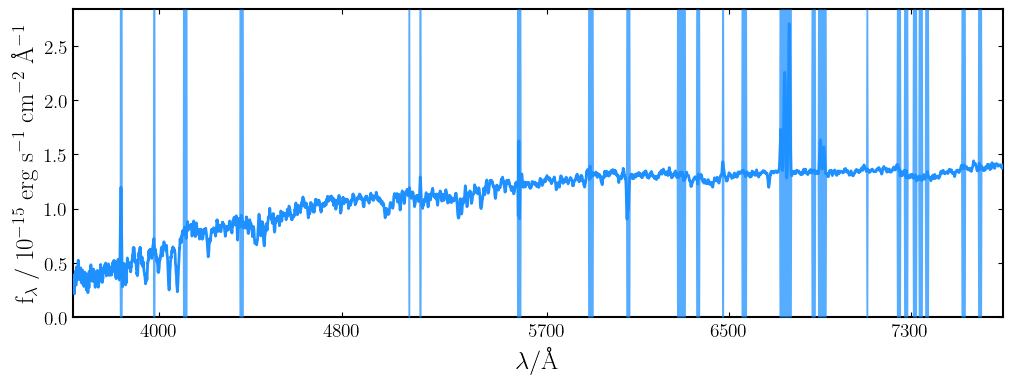

FileNotFoundError: [Errno 2] No such file or directory: 'gal_spec/input_spec_8324-12701_RPSB_centralspx_Pdemo_dpl_no_red_phot_dereddened_binby1_Rspec4340_nebularEM.pdf'

In [10]:
for i,ID_plateifu in enumerate(all_plateifu):

    # construct galID and runID
    run_params['ID_plateifu'] = ID_plateifu
    gal_ID = ID_plateifu+run_params['data_file_extension']
    run_params['runID'] = ID_plateifu + run_params['runID_extension']

    # set the MaNGA sampling rate Rspec
    pipes.config.R_spec = run_params['Rspec']

    # extract redshift from drpall NSA
    z = (all_zspec[(np.where(all_IDs==ID_plateifu))[0]])[0]
    # replace default redshifts for galaxies that seem to have faulty redshifts
    if ID_plateifu in list(replace_z['plateifu']):
        z = replace_z[replace_z['plateifu']==ID_plateifu]['z'].iloc[0]

    run_params['z'] = z

    # create bagpipes input galaxy object
    fit_obj = fitting(skylines_dir, run_params=run_params, full=False)
    if run_params['red_phot']:
        galaxy = pipes.galaxy(gal_ID, fit_obj.load_both, photometry_exists=True, filt_list=["filters/red_end.txt"])
    else:
        galaxy = pipes.galaxy(gal_ID, fit_obj.load_manga_spec, photometry_exists=False)
    if plotgal:
        # make a quick diagnostic plot of the loaded spectrum from the input galaxy object
        fig, ax = galaxy.plot()
        fig.savefig('gal_spec/input_spec_'+run_params['runID']+'.pdf')

    # get the fit instructions dictionary
    fit_instructions = get_fit_instructions(z, 
                                            GP=run_params['GP'], 
                                            dust_type=run_params['dust_type'],
                                            Av=run_params['Av'],
                                            eta=run_params['eta'],
                                            use_nebular=run_params['nebular'],
                                            zmet_lims=run_params['zmet_lims'],
                                            zmet_prior=run_params['zmet_prior'],
                                            GPtype=run_params['GPtype'],
                                            GPclamp=run_params['GPclamp'],
                                            SHOTerm_period_prior=run_params['SHOTerm_period_prior'],
                                            SHOTerm_norm_prior=run_params['SHOTerm_norm_prior'])
    print(fit_instructions)

    # save the run_params dictionary as a json file in posterior folder
    if run_params['runID'] not in os.listdir('pipes/posterior'):
        os.mkdir('pipes/posterior/'+run_params['runID'])
    a_file = open('pipes/posterior/'+run_params['runID']+'/'+gal_ID+".json", "w")
    json.dump(run_params, a_file, indent=4)
    a_file.close()

    if nofit == False:
        fit = pipes.fit(galaxy, fit_instructions, run=run_params['runID'], time_calls=False)

        fit.fit(
            verbose=True, 
            n_live=run_params['n_live'], 
            sampler=run_params['sampler'], 
            n_eff=run_params['n_eff'],
            pool=run_params['pool'], 
            discard_exploration=run_params['discard_exploration']
        )

    print('done fitting', gal_ID, '|', str(i+1)+'/'+str(len(all_plateifu)))